# <font color='greyblue'>Sentiment Analysis: Using Tf-idf Vectorizer</font>

## Loading the dataset
_______

In [2]:
import pandas as pd
df = pd.read_csv('movie_dataset.csv')

In [3]:
df.head(10)

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0
5,Leave it to Braik to put on a good show. Final...,1
6,Nathan Detroit (Frank Sinatra) is the manager ...,1
7,"To understand ""Crash Course"" in the right cont...",1
8,I've been impressed with Chavez's stance again...,1
9,This movie is directed by Renny Harlin the fin...,1


In [4]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer()
docs = (['The sun is shining',
         'The weather is sweet',
         'The sun is shining, the weather is sweet, and one and one is two'])
bag = count.fit_transform(docs)

print(count.vocabulary_)
print(bag.toarray())

{'the': 6, 'sun': 4, 'is': 1, 'shining': 3, 'weather': 8, 'sweet': 5, 'and': 0, 'one': 2, 'two': 7}
[[0 1 0 1 1 0 1 0 0]
 [0 1 0 0 0 1 1 0 1]
 [2 3 2 1 1 1 2 1 1]]


In [5]:
from sklearn.feature_extraction.text import TfidfTransformer
np.set_printoptions(precision=2)

tfidf = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)

print(tfidf.fit_transform(bag).toarray())

[[0.   0.43 0.   0.56 0.56 0.   0.43 0.   0.  ]
 [0.   0.43 0.   0.   0.   0.56 0.43 0.   0.56]
 [0.5  0.45 0.5  0.19 0.19 0.19 0.3  0.25 0.19]]


# Data Cleaning
___

In [6]:
import re
def preprocessor(text):
  text =re.sub('<[^>]*>', '', text)
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
  text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
  
  return text

preprocessor("This is a :) test :-( !")

'this is a test :) :('

In [7]:
# preprocess data
df['review'] = df['review'].apply(preprocessor)

# Tokenization
___

In [8]:
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()

def tokenizer(text):
  return text.split()

def tokenizer_stemmer(text):
  return[porter.stem(word) for word in text.split()]

tokenizer('runners like running thus they run')

['runners', 'like', 'running', 'thus', 'they', 'run']

In [9]:
tokenizer_stemmer('runners like running thus they run')

['runner', 'like', 'run', 'thu', 'they', 'run']

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\susya\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [11]:
from nltk.corpus import stopwords

stop = stopwords.words('english')
[w for w in tokenizer_stemmer('runners like running thus they run') if w not in stop]

['runner', 'like', 'run', 'thu', 'run']

# Transform Text Data into TF-IDF Vectors
___

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(strip_accents=None,
                         lowercase=True,
                         preprocessor=None,  # applied preprocessor in Data Cleaning
                         tokenizer=tokenizer_stemmer,
                         use_idf=True,
                         norm='l2',
                         smooth_idf=True)

y = df.sentiment.values
X = tfidf.fit_transform(df.review)

# Document Classification using Logistic Regression
___

In [14]:
from sklearn.model_selection import train_test_split
import pickle
from sklearn.linear_model import LogisticRegressionCV


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.5, shuffle=False)

clf = LogisticRegressionCV(cv=5,
                           scoring='accuracy',
                           random_state=0,
                           n_jobs=-1,
                           verbose=3,
                           max_iter=300).fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.9min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished


In [15]:
saved_model = open('saved_model.sav', 'wb')
pickle.dump(clf, saved_model)
saved_model.close()

# Model Evaluation
___

In [16]:
filename = 'saved_model.sav'
saved_clf = pickle.load(open(filename, 'rb'))

In [17]:
clf.score(X_test, y_test)

0.89608

In [18]:
yhat = clf.predict(X_test)
yhat

array([0, 1, 1, ..., 0, 1, 1], dtype=int64)

# Confusion matrix
____________

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))

[[11209  1264]
 [ 1334 11193]]


Confusion matrix, without normalization
[[11209  1264]
 [ 1334 11193]]


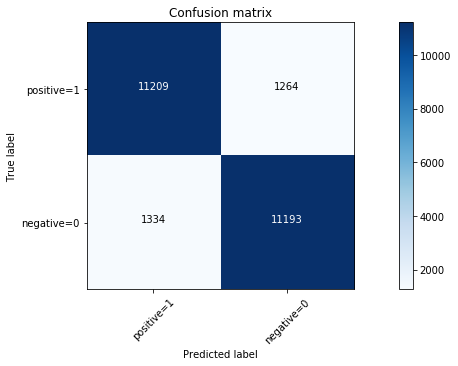

In [20]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure(figsize=(13,5))
plot_confusion_matrix(cnf_matrix, classes=['positive=1','negative=0'],normalize= False,  title='Confusion matrix')